Trial to calculate flow directions

In [325]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from osgeo import gdal
import geopandas as gpd
from itertools import repeat
import folium
import rasterio
import rioxarray as rxr
import xarray as xr

In [2]:
def distance_matrix(x0, y0, x1, y1):
    """ Make a distance matrix between pairwise observations.
    Note: from <http://stackoverflow.com/questions/1871536> 
    """
    
    obs = np.vstack((x0, y0)).T
    interp = np.vstack((x1, y1)).T

    d0 = np.subtract.outer(obs[:,0], interp[:,0])
    d1 = np.subtract.outer(obs[:,1], interp[:,1])
    
    # calculate hypotenuse
    return np.hypot(d0, d1)


def idw(x, y, z, xi, yi, power=2):
    """ Simple inverse distance weighted (IDW) interpolation 
    Weights are proportional to the inverse of the distance, so as the distance
    increases, the weights decrease rapidly.
    The rate at which the weights decrease is dependent on the value of power.
    As power increases, the weights for distant points decrease rapidly.
    """
    
    dist = distance_matrix(x,y, xi,yi)

    # In IDW, weights are 1 / distance
    weights = 1.0/(dist+1e-12)**power

    # Make weights sum to one
    weights /= weights.sum(axis=0)

    # Multiply the weights for each interpolated point by all observed Z-values
    return np.dot(weights.T, z)


def plot(x,y,z,grid):
    """ Plot the input points and the result """
    plt.figure(figsize=(15,10))
    plt.imshow(grid, extent=(x.min(), x.max(), y.max(), y.min()), cmap='rainbow')
    plt.scatter(x,y,c=z, cmap='rainbow', edgecolors='black')
    plt.colorbar()

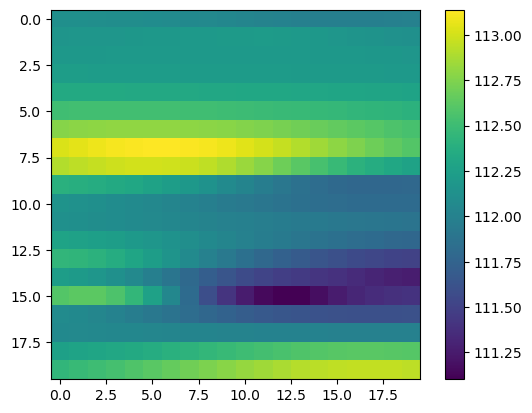

In [305]:
# create head dataframe
gridsize = 20
min_x = 13.93487159648860
max_x = 13.93490009687179
min_y = 50.96642525012349
max_y = 50.96662512913221

np.random.seed(20)
x = np.random.choice (np.arange(min_x, max_x, 1e-12), 10 )
y = np.random.choice(np.arange(min_y, max_y,  1e-12), 10)

df = pd.DataFrame(np.array ( [x, y] )).T
df.columns = ['x', 'y']
df.sort_values(by = 'y', ascending = False)

df['h'] = np.linspace(113.2, 111, 10)

# rng = np.random.default_rng(12345)
# h = rng.integers(low=110, high=115, size = 10)
x = df.x
y = df.y
h = df.h

# # size of the grid to interpolate
nx, ny = 20, 20 
# generate two arrays of evenly space data between ends of previous arrays
xi = np.linspace(x.min(), x.max(), nx)
yi = np.linspace(y.min(), y.max(), ny)
# # generate grid 
xi1, yi1 = np.meshgrid(xi, yi)

# # colapse grid into 1D
xi2, yi2 = xi1.flatten(), yi1.flatten()

# # Calculate IDW
grid1 = idw(x,y,h,xi2,yi2, power=2)
grid1 = grid1.reshape((ny, nx))

plt.imshow(grid1)
plt.colorbar()

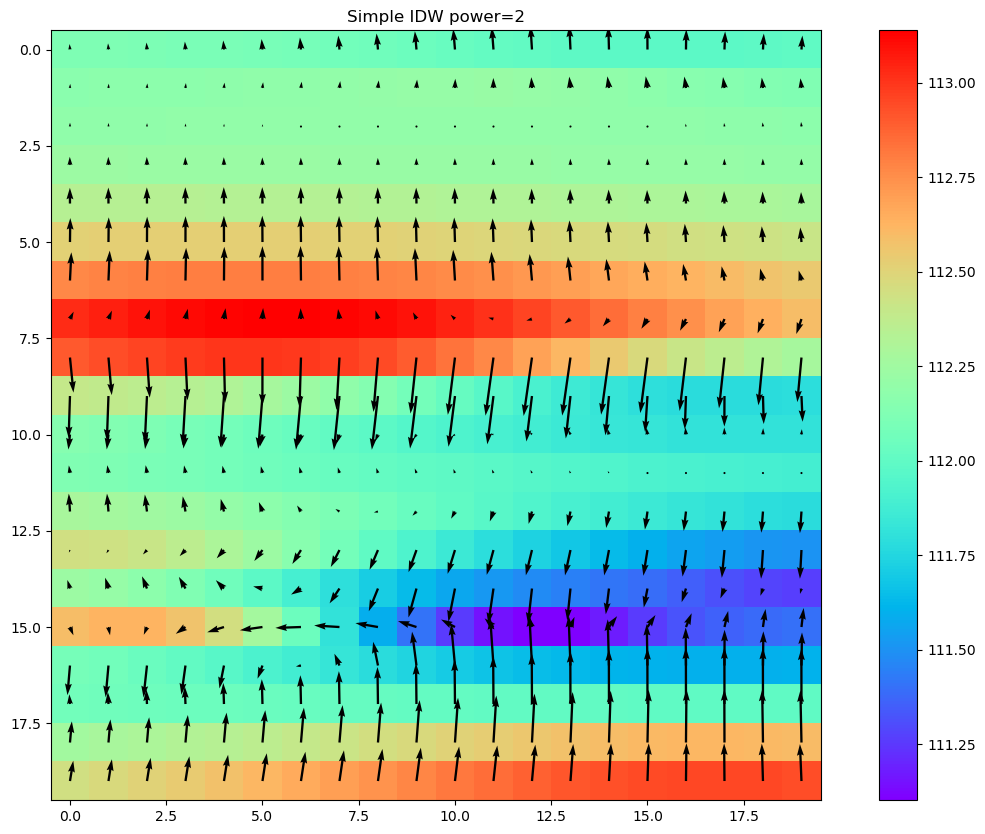

In [306]:
cellsize = 1
u, v = np.gradient(grid1, 1)
# slope = np.sqrt(px ** 2 + py ** 2)

x_coords = np.arange(0,grid1.shape[0],1)
y_coords = np.arange(0,grid1.shape[0],1)
plt.figure(figsize=(15,10))
plt.imshow(grid1,  cmap='rainbow')
plt.title('Simple IDW power=2')
plt.colorbar()
plt.quiver(x_coords, y_coords, v, u)
plt.show()

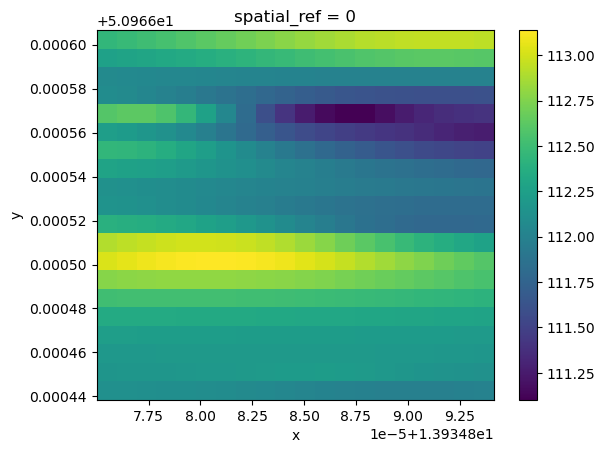

In [362]:
dataset = xr.DataArray (data = grid1,
              dims=["y", "x"],
              coords=dict( y = yi,
                            x = xi))
dataset = dataset.rio.write_crs("EPSG:4326")
dataset.plot()

In [364]:
dataset.rio.to_raster('test1.tif')

Driver: GTiff/GeoTIFF
Files: test1.tif
Size is 20, 20
Coordinate System is:
GEOGCRS["WGS 84",
    DATUM["World Geodetic System 1984",
        ELLIPSOID["WGS 84",6378137,298.257223563,
            LENGTHUNIT["metre",1]]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["geodetic latitude (Lat)",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXIS["geodetic longitude (Lon)",east,
            ORDER[2],
            ANGLEUNIT["degree",0.0174532925199433]],
    USAGE[
        SCOPE["Horizontal component of 3D system."],
        AREA["World."],
        BBOX[-90,-180,90,180]],
    ID["EPSG",4326]]
Data axis to CRS axis mapping: 2,1
Origin = (13.934875008383525,50.966438492457449)
Pixel Size = (0.000000957053812,0.000008406441827)
Metadata:
  AREA_OR_POINT=Area
Image Structure Metadata:
  INTERLEAVE=BAND
Corner Coordinates:
Upper Left  (  13.9348750,  50.9664385) ( 13d56' 5.55"E, 50d57'59.18

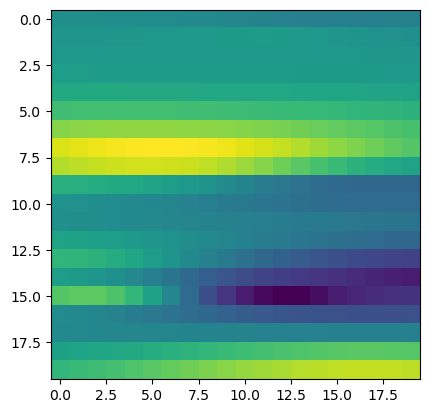

In [365]:
ds = gdal.Open('test1.tif')
arr = ds.ReadAsArray()

print(gdal.Info(ds))
plt.imshow(arr)

In [366]:
m = folium.Map(location=[50.97, 13.93], zoom_start = 13)


tile = folium.TileLayer(
        tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
        attr = 'Esri',
        name = 'Esri Satellite',
        overlay = False,
        control = True
       ).add_to(m)

In [367]:
folium.raster_layers.ImageOverlay(
    image='test1.tif',
    name="water levels",
    bounds=[[xi.min(), yi.min()], [xi.max(), yi.max()]],
    opacity=1
).add_to(m)

folium.LayerControl().add_to(m)


m

